## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [3]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`.

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
```
You can use:
```
np.add(b,c,out = a) # puts result in `a`
```

In [4]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

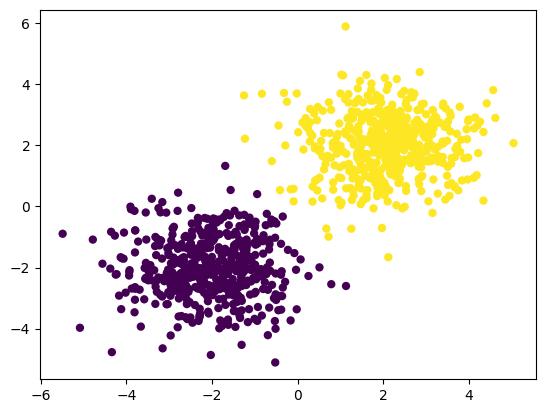

In [ ]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging.

In [ ]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [ ]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

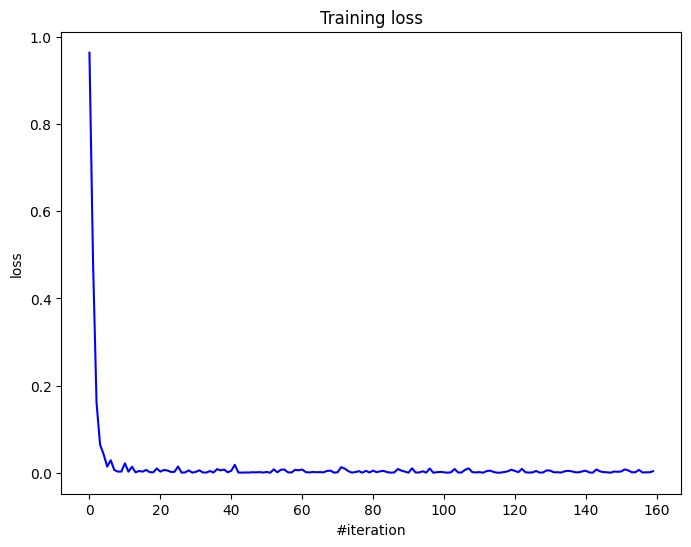

Current loss: 0.003473


In [ ]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

# Digit classification

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [8]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

File ‘mnist.py’ already there; not retrieving.



In [ ]:
#import mnist
#X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [9]:
import torch
from torchvision import datasets
from torchvision.transforms import transforms

In [10]:
 #Получение выборок
def GetMnist():
    even_shape = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.12,), (0.28,))
    ])
    train_dataset = datasets.MNIST(
        root='./data', train=True, download=True, transform=even_shape
    )
    test_dataset = datasets.MNIST(
        root='./data', train=False, transform=even_shape
    )
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size]
    )
    def dataset_to_numpy(dataset):
        loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))
        X, y = next(iter(loader))
        return X.numpy().reshape(len(X), -1), y.numpy()
    X_train, y_train = dataset_to_numpy(train_dataset)
    X_val, y_val = dataset_to_numpy(val_dataset)
    X_test, y_test = dataset_to_numpy(test_dataset)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = GetMnist()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.07MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



One-hot encode the labels first.

In [12]:
# Your code goes here. ################################################


# Define a function to one-hot encode labels
def one_hot_encode(labels):
  """Converts labels to one-hot encoded tensors."""
  n_classes = 10  # Number of classes in MNIST
  return np.eye(n_classes)[labels]

# Apply one-hot encoding to the labels

y_train = one_hot_encode(y_train)
y_val = one_hot_encode(y_val)
y_test = one_hot_encode(y_test)
# Access the first element with one-hot encoded label
print(y_train)
print(y_val)
print(y_test)





[[0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5.

In [ ]:
optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state = {}

# Параметры для обучение
n_epoch = 10
batch_size = 128

In [ ]:
a, b, X_train_size, y_train_size = X_train.shape[0], y_train.shape[0], X_train.shape[1], y_train.shape[1]

a, b, X_train_size, y_train_size

(48000, 48000, 784, 10)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
Q_relu = []
Q_elu = []
Q_leaky_relu = []
Q_softplus = []

def net_runing(act_func, loss_history, name):
    """
    Функция осуществляет обучение базовой нейронной сети с применением заданной функции активации.
     В процессе работы она принимает два основных параметра:
     класс функции активации для использования в нейронных слоях
     и список для сохранения истории значений функции потерь на каждой итерации обучения.
     Такой подход позволяет отслеживать процесс обучения и анализировать эффективность выбранной функции активации.
    """

    # Архитектура сети
    net = Sequential()
    net.add(Linear(X_train_size, 200))
    net.add(act_func())
    net.add(Linear(200, y_train_size))
    net.add(LogSoftMax())
    print(net)

    criterion = ClassNLLCriterion()


    for epoch in range(n_epoch):
        for start_idx in range(0, len(X_train), batch_size):
            end_idx = start_idx + batch_size
            x_batch = X_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]

            net.zeroGradParameters()

            # Прямой проход
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Обратный проход
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Обновление параметров
            sgd_momentum(net.getParameters(),
                         net.getGradParameters(),
                         optimizer_config,
                         optimizer_state)

            loss_history.append(loss)

    # Визуализация функции потерь
    plt.figure(figsize=(8, 6))
    plt.title(name + ": Потери при обучении")
    plt.xlabel("#итерация")
    plt.ylabel("потери")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)



Linear 784 -> 200
ReLU
Linear 200 -> 10
LogSoftMax



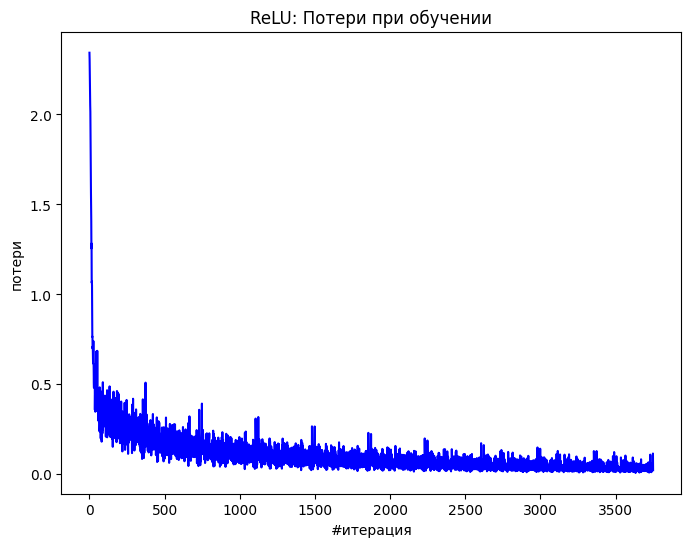

Current loss: 0.021021


In [ ]:
net_runing(ReLU, Q_relu, "ReLU")

Linear 784 -> 200
ELU
Linear 200 -> 10
LogSoftMax



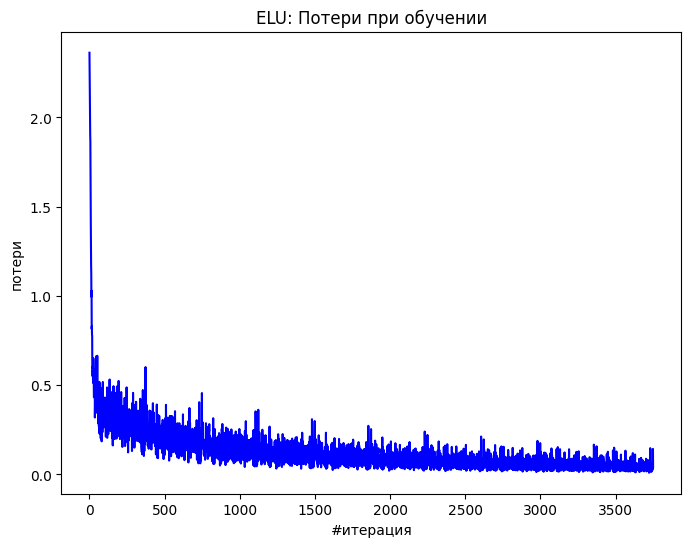

Current loss: 0.040386


In [ ]:
net_runing(ELU, Q_elu, "ELU")

Linear 784 -> 200
LeakyReLU
Linear 200 -> 10
LogSoftMax



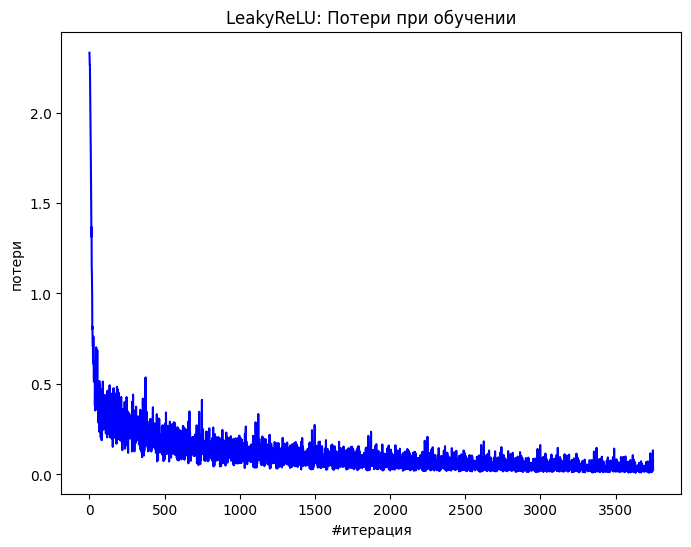

Current loss: 0.021326


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_runing(LeakyReLU, Q_leaky_relu, "LeakyReLU")

Linear 784 -> 200
SoftPlus
Linear 200 -> 10
LogSoftMax



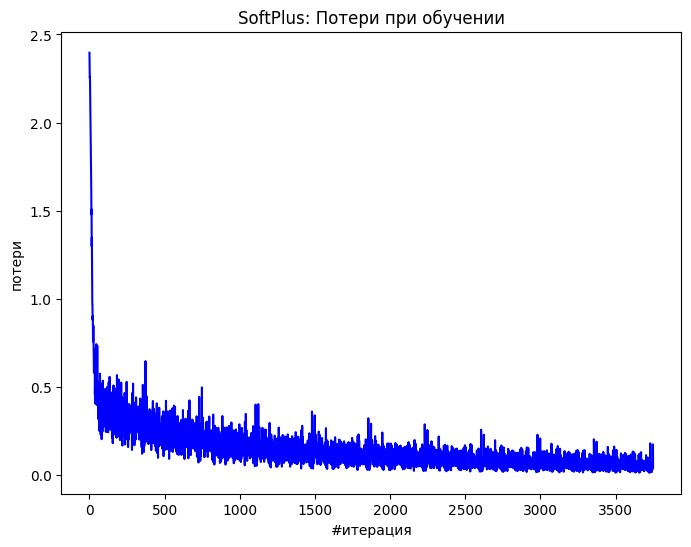

Current loss: 0.048106


In [ ]:
net_runing(SoftPlus, Q_softplus, "SoftPlus")

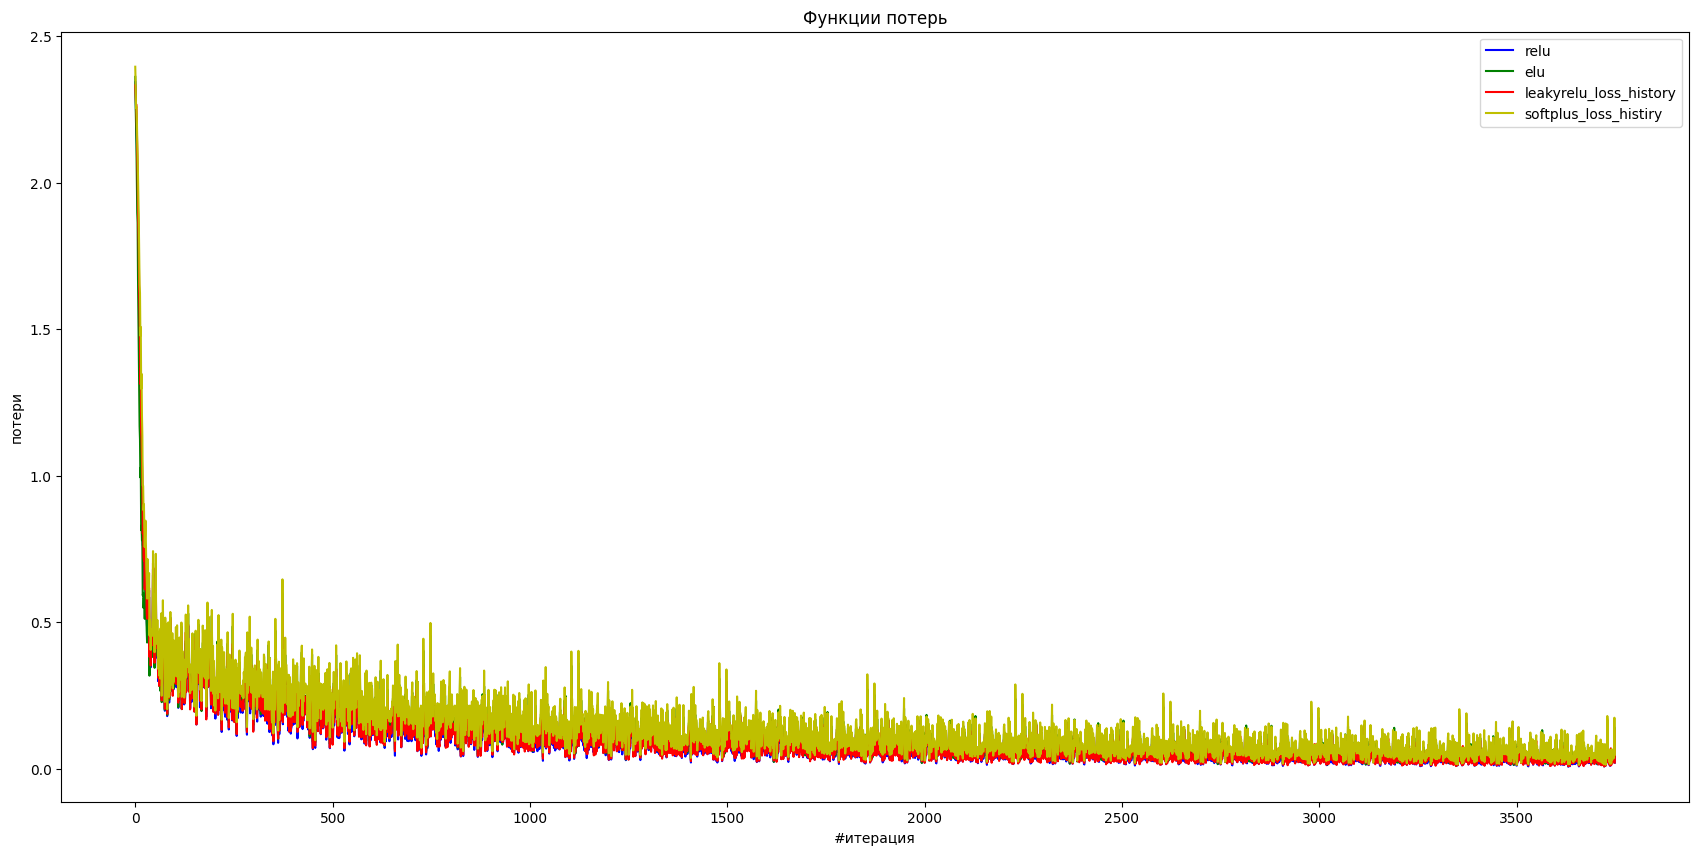

In [ ]:
# все вместе
plt.figure(figsize=(21, 10))
plt.title("Функции потерь")
plt.xlabel("#итерация")
plt.ylabel("потери")

plt.plot(Q_relu, 'b', label='relu')
plt.plot(Q_elu, 'g', label='elu')
plt.plot(Q_leaky_relu, 'r', label='leakyrelu_loss_history')
plt.plot(Q_softplus, 'y', label='softplus_loss_histiry')
plt.legend()
plt.show()

Linear 784 -> 200
BatchNormalization
ReLU
Linear 200 -> 10
LogSoftMax

Потери: ReLU - 0.024778489966445008
Linear 784 -> 200
BatchNormalization
ELU
Linear 200 -> 10
LogSoftMax

Потери: ELU - 0.05545245192888716
Linear 784 -> 200
BatchNormalization
LeakyReLU
Linear 200 -> 10
LogSoftMax

Потери: LeakReLU - 0.029778348580252724
Linear 784 -> 200
BatchNormalization
SoftPlus
Linear 200 -> 10
LogSoftMax

Потери: SoftPlus - 0.08511015692958476


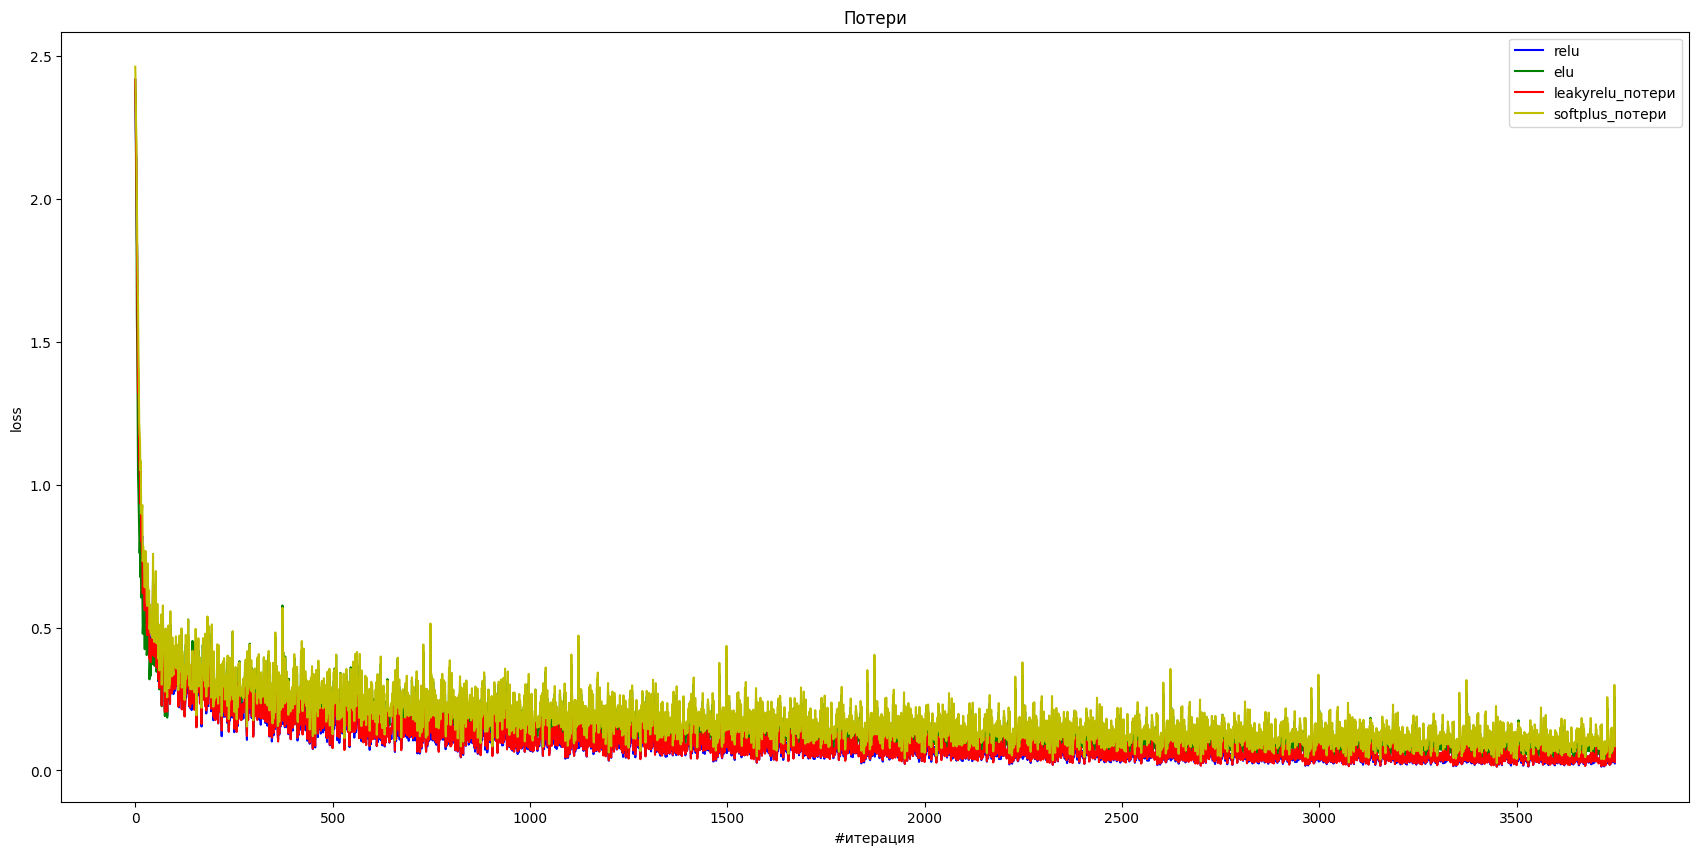

In [ ]:
#Применим BatchNormalization
Q_relu = []
Q_elu = []
Q_leaky_relu = []
Q_softplus = []

def net_runing_activations_batch(activation_function, lossex, Function_naming):

  # архитектура сети с добавлением BatchNormalization
    net = Sequential()
    net.add(Linear(X_train_size, 200))
    net.add(BatchNormalization())
    net.add(activation_function())
    net.add(Linear(200, y_train_size))
    net.add(LogSoftMax())
    print(net)

    criterion = ClassNLLCriterion()


    for epoch in range(n_epoch):
        for start_idx in range(0, len(X_train), batch_size):
            end_idx = start_idx + batch_size
            x_batch = X_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]

            net.zeroGradParameters()

            # Прямой проход
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Обратный проход
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Обновление весов
            sgd_momentum(net.getParameters(),
                         net.getGradParameters(),
                         optimizer_config,
                         optimizer_state)

            lossex.append(loss)

    print('Потери: {} - {}'.format(Function_naming, loss))

# запуск функций активации
net_runing_activations_batch(ReLU, Q_relu, 'ReLU')
net_runing_activations_batch(ELU, Q_elu, 'ELU')
net_runing_activations_batch(LeakyReLU, Q_leaky_relu, 'LeakReLU')
net_runing_activations_batch(SoftPlus, Q_softplus, 'SoftPlus')

plt.figure(figsize=(21, 10))
plt.title("Потери")
plt.xlabel("#итерация")
plt.ylabel("loss")

plt.plot(Q_relu, 'b', label='relu')
plt.plot(Q_elu, 'g', label='elu')
plt.plot(Q_leaky_relu, 'r', label='leakyrelu_потери')
plt.plot(Q_softplus, 'y', label='softplus_потери')
plt.legend()
plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

Анализ функций активации в нейронных сетях показывает различные преимущества и ограничения каждого метода. ReLU отличается максимальной скоростью вычислений и эффективным решением проблемы затухающего градиента, но имеет риск возникновения "умирающих нейронов". ELU обеспечивает более плавный градиент и лучшее центрирование активаций, однако требует больших вычислительных ресурсов. LeakyReLU успешно решает проблему "умирающих нейронов" и работает быстрее ELU, но требует дополнительной настройки параметров. SoftPlus предлагает гладкую аппроксимацию ReLU с полной дифференцируемостью, но является самой медленной функцией.

BatchNormalization выступает важным инструментом стабилизации обучения, позволяя ускорить процесс и использовать более высокие значения learning rate. По вычислительной эффективности функции располагаются в следующем порядке: ReLU, LeakyReLU, ELU, SoftPlus.

Для большинства задач рекомендуется использовать ReLU, при необходимости избежать "умирающих нейронов" - LeakyReLU, для сложных архитектур - ELU, а SoftPlus применяется в специфических случаях.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

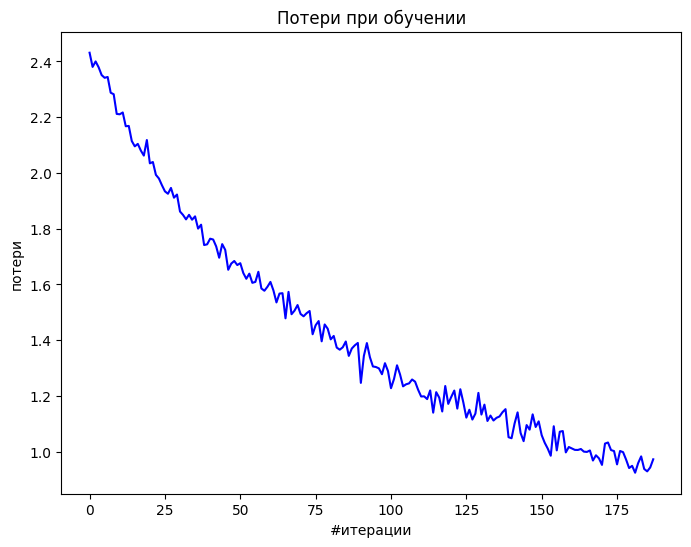

Потери на данном этапе: 0.972090


In [13]:
import torch
# Your code goes here. ################################################
# Параметры оптимизации

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer_config = {'learning_rate' : 0.002, 'momentum': 0.8}
optimizer_state = {}

# Параметры для обучение
n_epoch = 15
batch_size = 100

# Архитектура сети
net = Sequential()
net.add(Linear(784, 500))
net.add(BatchNormalization())
net.add(LeakyReLU())
net.add(Linear(500, 256))
net.add(BatchNormalization())
net.add(LeakyReLU())
net.add(Linear(256, 200))
net.add(BatchNormalization())
net.add(LeakyReLU())
net.add(Dropout())
net.add(Linear(200, 64))
net.add(BatchNormalization())
net.add(LeakyReLU())
net.add(Linear(64, 10))
net.add(LogSoftMax())
print(net)

criterion = ClassNLLCriterion()


n_epoch = 1
batch_size = 256

loss_history = []

for i in range(n_epoch):
    for start_idx in range(0, len(X_train), batch_size):
        end_idx = start_idx + batch_size
        x_batch = X_train[start_idx:end_idx]
        y_batch = y_train[start_idx:end_idx]

        net.zeroGradParameters()

        # Прямой проход
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Обратный проход
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Обновление весов
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Визиализация данных
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Потери при обучении")
    plt.xlabel("#итерации")
    plt.ylabel("потери")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Потери на данном этапе: %f' % loss)

Print here your accuracy on test set. It should be around 90%.

In [14]:
# Your answer goes here. ################################################
#вычисляем accuracy
from sklearn.metrics import accuracy_score

net.evaluate()
predictions = net.forward(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

accuracy = np.mean(predicted_classes == true_classes) * 100

print('accuracy on test set %f' % accuracy)

accuracy on test set 86.110000


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

Epoch 1/30 - Train Loss: 0.3262, Train Accuracy: 0.9081, Val Loss: 0.1439, Val Accuracy: 0.9591
Epoch 2/30 - Train Loss: 0.1710, Train Accuracy: 0.9530, Val Loss: 0.1126, Val Accuracy: 0.9673
Epoch 3/30 - Train Loss: 0.1337, Train Accuracy: 0.9636, Val Loss: 0.0942, Val Accuracy: 0.9730
Epoch 4/30 - Train Loss: 0.1044, Train Accuracy: 0.9713, Val Loss: 0.0989, Val Accuracy: 0.9719
Epoch 5/30 - Train Loss: 0.0918, Train Accuracy: 0.9739, Val Loss: 0.0831, Val Accuracy: 0.9773
Epoch 6/30 - Train Loss: 0.0781, Train Accuracy: 0.9777, Val Loss: 0.0820, Val Accuracy: 0.9776
Epoch 7/30 - Train Loss: 0.0714, Train Accuracy: 0.9801, Val Loss: 0.0845, Val Accuracy: 0.9764
Epoch 8/30 - Train Loss: 0.0607, Train Accuracy: 0.9828, Val Loss: 0.0778, Val Accuracy: 0.9802
Epoch 9/30 - Train Loss: 0.0512, Train Accuracy: 0.9847, Val Loss: 0.0819, Val Accuracy: 0.9792
Epoch 10/30 - Train Loss: 0.0503, Train Accuracy: 0.9849, Val Loss: 0.0755, Val Accuracy: 0.9808
Epoch 11/30 - Train Loss: 0.0474, Train

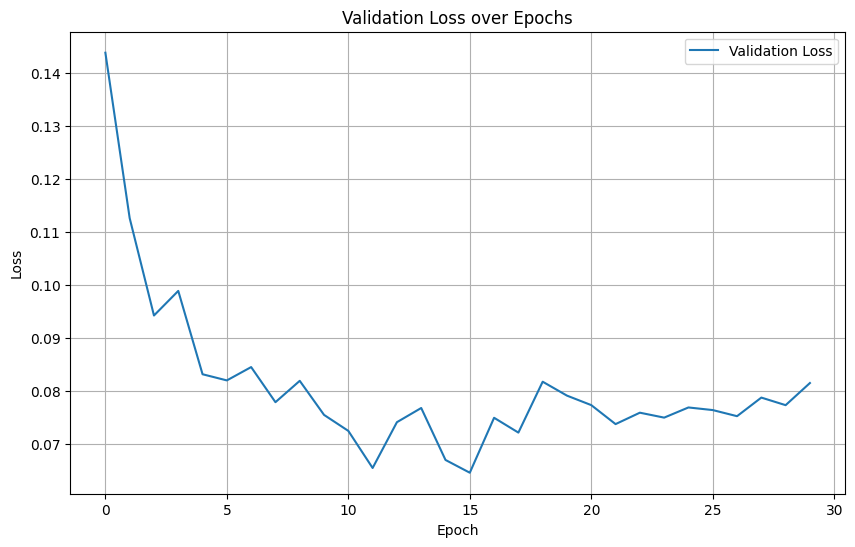

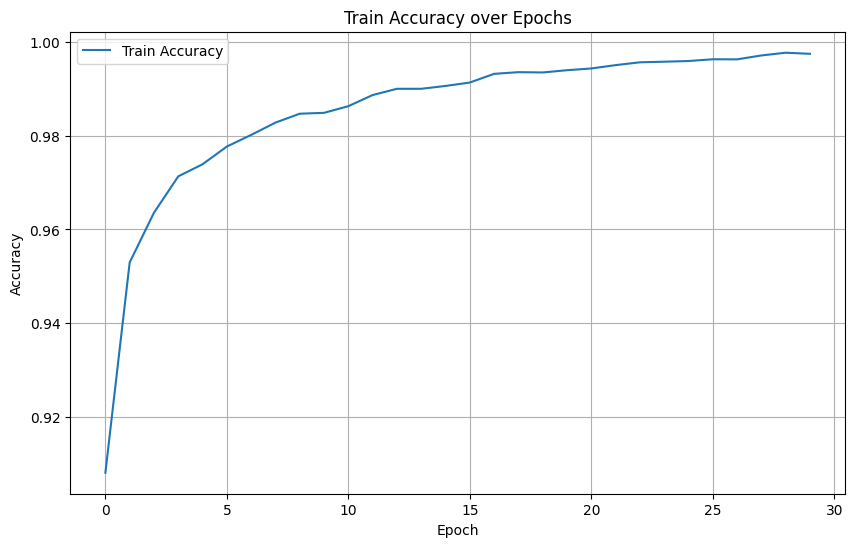

Test Accuracy: 98.44%


In [15]:

# Your beautiful code here.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
import numpy as np



# Подготовка данных с Augmentation
def prepare_augmented_data(X_train, y_train, X_val, y_val, X_test, y_test):
    transform = transforms.Compose([
        transforms.ToPILImage(),  # Convert numpy array to PIL Image
        transforms.RandomRotation(15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),  # Convert PIL Image back to Tensor
    ])

    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)

    # Подготовка данных для PyTorch перевод в Tensor
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                 torch.LongTensor(y_val))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                  torch.LongTensor(y_test))

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128)
    test_loader = DataLoader(test_dataset, batch_size=128)

    return train_loader, val_loader, test_loader


# архитектура сети через PyTorch
class MNIST_Model(nn.Module):
    def __init__(self):
        super(MNIST_Model, self).__init__()
        self.fc1 = nn.Linear(784, 612)
        self.bn1 = nn.BatchNorm1d(612)
        self.dropout1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(612, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(512, 460)
        self.bn3 = nn.BatchNorm1d(460)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(460, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.dropout4 = nn.Dropout(0.3)

        self.fc5 = nn.Linear(256, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.dropout5 = nn.Dropout(0.4)

        self.fc6 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)

        x = F.relu(self.bn5(self.fc5(x)))
        x = self.dropout5(x)

        x = self.fc6(x)
        return F.log_softmax(x, dim=1)


# Функция обучения с отслеживанием потерь
def train_model(model, optimizer, criterion, train_loader, val_loader, scheduler, epochs=20):
    train_losses, val_losses, train_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Обучающий цикл
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            Y_batch = Y_batch.argmax(dim=1)
            loss = criterion(output, Y_batch)
            loss.backward()
            optimizer.step()

            # Отслеживание потерь при обучении и точности
            train_loss += loss.item()
            _, preds = torch.max(output, 1)
            correct_train += (preds == Y_batch).sum().item()
            total_train += Y_batch.size(0)

        scheduler.step()  # Обновление learning rate в конце прохода отдельной epoch

        # Сохранение значений потерь и точности
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Цикл валидации
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                output = model(X_batch)
                Y_batch = Y_batch.argmax(dim=1)
                val_loss += criterion(output, Y_batch).item()
                _, preds = torch.max(output, 1)
                correct_val += (preds == Y_batch).sum().item()
                total_val += Y_batch.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_val / total_val
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {correct_train/total_train:.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}")

    return train_losses, train_accuracies, val_losses


# Функция оценки
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            output = model(X_batch)
            _, preds = torch.max(output, 1)
            Y_batch = Y_batch.argmax(dim=1)
            correct += (preds == Y_batch).sum().item()
            total += Y_batch.size(0)
    return correct / total


# Подготовка данных
train_loader, val_loader, test_loader = prepare_augmented_data(X_train, y_train, X_val, y_val, X_test, y_test)

# Определение модели
model = MNIST_Model()

# Optimizer, Scheduler, и Loss
optimizer = Adam(model.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.95)
criterion = nn.NLLLoss()

# Train Model
train_losses, train_accuracies, val_losses = train_model(model, optimizer, criterion, train_loader, val_loader, scheduler, epochs=30)

# Визиализация Loss
plt.figure(figsize=(10, 6))
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Визиализация Train Accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Получаем точность
accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy: {accuracy:.2%}")


PyTorch представляет собой мощный инструмент для разработки нейронных сетей, обладающий тремя ключевыми преимуществами. Во-первых, его модульная архитектура предоставляет широкий набор готовых компонентов и слоев, что существенно упрощает процесс создания сложных нейронных сетей. Во-вторых, встроенный механизм автоматического дифференцирования избавляет разработчиков от необходимости вручную реализовывать обратное распространение ошибки. В-третьих, использование динамической вычислительной графики в сочетании с поддержкой GPU через CUDA обеспечивает высокую производительность при работе с масштабными моделями и большими наборами данных.